In [1]:
! pip install ONE-api
! pip install ibllib

from google.colab import drive
drive.mount('/content/gdrive')
import os

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

Helper functions

In [51]:
# move_times = [time for time in trials['firstMovement_times'] if time == time]


def remove_nans(lis, indices):
    tes = np.array([[i,val] for i,val in enumerate(lis)])
    # print(tes)
    row_remove = np.argwhere(np.isnan(tes))
    # print("***")
    # print(row_remove)
    tes = tes[~np.isnan(tes).any(axis=1)]

    return tes, row_remove[:,0]

# move_times, removed_trials = remove_nans(trials['firstMovement_times'])
# print(len(trials['firstMovement_times']), len(move_times))
# print(removed_trials)

def get_spikedata_pid(PID):
    sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    return spikes, clusters, channels

def get_spikedata_eid(eid):
    PIDlist = one.eid2pid(eid)
    datalist = []
    print(PIDlist)
    for PID in PIDlist[0]:
        sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
        spikes, clusters, channels = sl.load_spike_sorting()
        clusters = sl.merge_clusters(spikes, clusters, channels)
        datalist.append([spikes, clusters, channels])
    return datalist

def select_trials(trial_data, trial_condition, condition):
    indices = [i for i, trial in enumerate(trial_data) if trial_condition[i] == condition and not math.isnan(trial)]
    result = [trial for i, trial in enumerate(trial_data) if i in indices]
    return result, indices


def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1, trial_def = [3,3,0.05]):


    move_trials, trial_indices = select_trials(trials['firstMovement_times'], trials[param], param_condition)
    print(len(move_trials), move_trials)
    print(len(trial_indices), trial_indices)

    #0D behavioral parameters 
    movement_choices = trials.choice[trial_indices]
    trial_results = trials.feedbackType[trial_indices]
    print(len(movement_choices))

    peth, spike_counts = calculate_peths(
        spikes.times, spikes.clusters, relev_neur,
        move_trials,
        pre_time=trial_def[0], post_time=trial_def[1], bin_size=trial_def[2], smoothing=0)

    print('peth["tscale"] contains the timebin centers relative to the event')
    print(f'\npeth["means"] is shaped: {peth["means"].shape}')
    print('This variable is NxB (neurons x timebins) and contains the mean spike rates over trials')
    print(f'\nspike_counts is shaped: {spike_counts.shape}')
    print('This variable is TxNxB (trials x neurons x timebins) and contains all spike rates per trial')

    # If you just want all the spikes over the entire 0-300 ms window you can sum like this:
    whole_window = np.sum(spike_counts, axis=2)

    print(np.linalg.norm(whole_window))
    print(f'\nwhole_window is shaped: {whole_window.shape}')
    print('This variable is TxN (trials x neurons) and contains summed spike rates per trial')

    trial_data = {}
    trial_data['movement_init_times'] = move_trials
    trial_data['choices'] = movement_choices
    trial_data['feedback'] = trial_results
    trial_data['trial_indices'] = trial_indices

    return peth, spike_counts, trial_data

# get_matrices(trials, spikes, relev_neur)

def gen_eidlist(roi_name):
    ses = one.alyx.rest('sessions', 'list', atlas_acronym=roi_name)
    eids = [i['id'] for i in ses]
    return eids

def gen_pidlist(roi_name):
    ses = one.alyx.rest('insertions', 'list', atlas_acronym=roi_name)
    # print(f'Found {len(ses)} recordings')
    pids = [i['id'] for i in ses]
    return pids

def check_num_ses(list_of_eids):
    roi_intersection = set(list_of_eids[0]).intersection(*list_of_eids[1:])
    print('Found ' + str(len(list(roi_intersection))) +  'recording sessions')
    return len(list(roi_intersection))

**Projectome data loading**

In [182]:
projectome = pd.read_excel('proj_strengths_sup3.xlsx', sheet_name='W_ipsi', index_col = 0)
print("Source is rows, Target is columns")

Source is rows, Target is columns


/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [184]:
projec_roi = projectome.columns

In [209]:
rois_opt

['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']

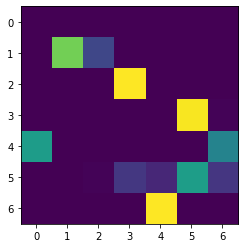

In [229]:
strengths = np.zeros([7,7])
for i,source in enumerate(rois_opt):
    for j, target in enumerate(rois_opt):
        # print(round(projectome.loc[source, target], 2))
        strengths[i,j] = projectome.loc[source, target]
    if np.sum(strengths[i,:]) > 0:
        strengths[i,:] /= np.sum(strengths[i,:])
plt.imshow(strengths)
strength_df = pd.DataFrame(strengths, columns = rois_opt, index = rois_opt)

In [230]:
strength_df

,CM,DG,CA1,LP,MRN,PTLp,APN
CM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DG,0.000000,0.786168,0.213832,0.000000,0.000000,0.000000,0.000000
CA1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
LP,0.000000,0.000000,0.000000,0.000000,0.000000,0.988383,0.011617
MRN,0.554347,0.000000,0.000000,0.000000,0.000000,0.000000,0.445653
PTLp,0.000070,0.000000,0.010600,0.162417,0.111364,0.557438,0.158112
APN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [228]:
strengths[,:]

array([0., 0., 0., 1., 0., 0., 0.])

1.5) Other dataset gen

In [23]:
example_regions = ['VM']#, 'VAL']#, 'MOp']

In [63]:
regions = [region[0] for region in pd.read_csv('chosen_brainregions.csv', header = None).values]
print(regions)

['LP', 'CP', 'MOp', 'MOs', 'VM', 'VAL', 'CA1', 'SCm', 'VPM', 'VISp', 'MRN', 'DG', 'CA1', 'PTLp']


In [65]:
ignorelist = ['1b20f589-6177-4e5c-9090-9a609a16944b', 'b01df337-2d31-4bcc-a1fe-7112afd50c50']
for region in regions:
  if region in regions[:4]:
    continue

  print(region)
  eids = gen_eidlist(region)
  pids = gen_pidlist(region)
  for i,eid in enumerate(eids):
    if eid in ignorelist:
      continue
    if i >= 10:
      print("breakin")
      break
    print(eid)
    trial = one.load_object(eid, "trials")
                  

VM
63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
1b715600-0cbc-442c-bd00-5b0ac2865de1
1f095590-6669-46c9-986b-ccaf0620c5e9
71e03be6-b497-4991-a121-9416dcc1a6e7
9a629642-3a9c-42ed-b70a-532db0e86199
5386aba9-9b97-4557-abcd-abc2da66b863
f8d5c8b0-b931-4151-b86c-c471e2e80e5d
ee40aece-cffd-4edb-a4b6-155f158c666a
d33baf74-263c-4b37-a0d0-b79dcb80a764
VAL
63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
948fd27b-507b-41b3-bdf8-f9f5f0af8e0b
c7bd79c9-c47e-4ea5-aea3-74dda991b48e
5adab0b7-dfd0-467d-b09d-43cb7ca5d59c
9a629642-3a9c-42ed-b70a-532db0e86199
034e726f-b35f-41e0-8d6c-a22cc32391fb
5386aba9-9b97-4557-abcd-abc2da66b863
741979ce-3f10-443a-8526-2275620c8473
d33baf74-263c-4b37-a0d0-b79dcb80a764
CA1
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
27ef44c0-acb2-4220-b776-477d0d5abd35
a2701b93-d8e1-47e9-a819-f1063046f3e7


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.25k/4.25k [00:00<00:00, 18.7kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.table.pqt: 100%|██████████| 44.3k/44.3k [00:00<00:00, 910kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.25k/4.25k [00:00<00:00, 87.8kB/s]


446f4724-1690-49f9-819a-2bd8e2ea88ce


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 56.5k/56.5k [00:00<00:00, 91.8kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-20/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.74k/5.74k [00:00<00:00, 86.1kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-20/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.74k/5.74k [00:00<00:00, 120kB/s]


8928f98a-b411-497e-aa4b-aa752434686d
3f859b5c-e73a-4044-b49e-34bb81e96715


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS094/2022-06-17/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.05k/4.05k [00:00<00:00, 52.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS094/2022-06-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 42.2k/42.2k [00:00<00:00, 443kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS094/2022-06-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.05k/4.05k [00:00<00:00, 78.9kB/s]


5b49aca6-a6f4-4075-931a-617ad64c219c


/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-10/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.31k/6.31k [00:00<00:00, 51.0kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.31k/6.31k [00:00<00:00, 117kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-10/001/alf/_ibl_trials.table.pqt: 100%|██████████| 61.3k/61.3k [00:00<00:00, 688kB/s]


eacc49a9-f3a1-49f1-b87f-0972f90ee837


/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-09/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.66k/6.66k [00:00<00:00, 127kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 64.2k/64.2k [00:00<00:00, 750kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-09/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.66k/6.66k [00:00<00:00, 68.9kB/s]


3e6a97d3-3991-49e2-b346-6948cb4580fb
breakin
SCm
e0928e11-2b86-4387-a203-80c77fab5d52


/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.92k/3.92k [00:00<00:00, 55.3kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.92k/3.92k [00:00<00:00, 82.0kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-07-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.2k/41.2k [00:00<00:00, 523kB/s]


f819d499-8bf7-4da0-a431-15377a8319d5


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-16/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.66k/3.66k [00:00<00:00, 32.1kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-16/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.66k/3.66k [00:00<00:00, 67.9kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-16/001/alf/_ibl_trials.table.pqt: 100%|██████████| 39.1k/39.1k [00:00<00:00, 669kB/s]


1b9e349e-93f2-41cc-a4b5-b212d7ddc8df


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 86.7k/86.7k [00:00<00:00, 788kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 126kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS096/2022-06-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 9.25k/9.25k [00:00<00:00, 149kB/s]


eacc49a9-f3a1-49f1-b87f-0972f90ee837
90e524a2-aa63-47ce-b5b8-1b1941a1223a


/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-23/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.48k/3.48k [00:00<00:00, 61.3kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-23/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.48k/3.48k [00:00<00:00, 70.6kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-23/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.3k/37.3k [00:00<00:00, 419kB/s]


111c1762-7908-47e0-9f40-2f2ee55b6505


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.92k/5.92k [00:00<00:00, 82.3kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.1k/58.1k [00:00<00:00, 1.54MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.92k/5.92k [00:00<00:00, 83.7kB/s]


111c1762-7908-47e0-9f40-2f2ee55b6505
19b44992-d527-4a12-8bda-aa11379cb08c
8a3a0197-b40a-449f-be55-c00b23253bbf
58c4bf97-ec3b-45b4-9db4-d5d9515d5b00


/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 42.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.6k/37.6k [00:00<00:00, 688kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 72.3kB/s]


breakin
VPM
63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
19e66dc9-bf9f-430b-9d6a-acfa85de6fb7


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA006/2021-12-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.11k/6.11k [00:00<00:00, 124kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA006/2021-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.11k/6.11k [00:00<00:00, 142kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA006/2021-12-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 59.7k/59.7k [00:00<00:00, 838kB/s]


c7bf2d49-4937-4597-b307-9f39cb1c7b16
51e53aff-1d5d-4182-a684-aba783d50ae5
c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9
0802ced5-33a3-405e-8336-b65ebc5cb07c
0802ced5-33a3-405e-8336-b65ebc5cb07c
d2832a38-27f6-452d-91d6-af72d794136c
a4a74102-2af5-45dc-9e41-ef7f5aed88be
30c4e2ab-dffc-499d-aae4-e51d6b3218c2


/root/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.86k/6.86k [00:00<00:00, 85.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.table.pqt: 100%|██████████| 65.8k/65.8k [00:00<00:00, 757kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-02370/2021-04-29/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.86k/6.86k [00:00<00:00, 88.0kB/s]


breakin
VISp
e0928e11-2b86-4387-a203-80c77fab5d52
e0928e11-2b86-4387-a203-80c77fab5d52
0c828385-6dd6-4842-a702-c5075f5f5e81
9a6e127b-bb07-4be2-92e2-53dd858c2762


/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 90.8kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.table.pqt: 100%|██████████| 53.0k/53.0k [00:00<00:00, 812kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 70.5kB/s]


111c1762-7908-47e0-9f40-2f2ee55b6505
bda2faf5-9563-4940-a80f-ce444259e47b


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA037/2022-02-10/001/alf/_ibl_trials.table.pqt: 100%|██████████| 46.3k/46.3k [00:00<00:00, 691kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA037/2022-02-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.49k/4.49k [00:00<00:00, 89.6kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA037/2022-02-10/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.49k/4.49k [00:00<00:00, 79.2kB/s]


8a3a0197-b40a-449f-be55-c00b23253bbf
bb099402-fb31-4cfd-824e-1c97530a0875


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA017/2021-11-16/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.45k/5.45k [00:00<00:00, 91.1kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA017/2021-11-16/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.45k/5.45k [00:00<00:00, 65.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA017/2021-11-16/002/alf/_ibl_trials.table.pqt: 100%|██████████| 54.2k/54.2k [00:00<00:00, 707kB/s]


f140a2ec-fd49-4814-994a-fe3476f14e66
58b1e920-cfc8-467e-b28b-7654a55d0977


/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.4k/58.4k [00:00<00:00, 1.25MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.95k/5.95k [00:00<00:00, 91.1kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.95k/5.95k [00:00<00:00, 89.9kB/s]


breakin
MRN
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
e0928e11-2b86-4387-a203-80c77fab5d52
1ca83b26-30fc-4350-a616-c38b7d00d240


/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-30/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.82k/4.82k [00:00<00:00, 86.4kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-30/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.82k/4.82k [00:00<00:00, 83.1kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0021/2022-06-30/002/alf/_ibl_trials.table.pqt: 100%|██████████| 49.0k/49.0k [00:00<00:00, 997kB/s]


1b9e349e-93f2-41cc-a4b5-b212d7ddc8df
d901aff5-2250-467a-b4a1-0cb9729df9e2
eacc49a9-f3a1-49f1-b87f-0972f90ee837
3e6a97d3-3991-49e2-b346-6948cb4580fb
9b528ad0-4599-4a55-9148-96cc1d93fb24
0c828385-6dd6-4842-a702-c5075f5f5e81
breakin
DG
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
1d4a7bd6-296a-48b9-b20e-bd0ac80750a5
e0928e11-2b86-4387-a203-80c77fab5d52
1ca83b26-30fc-4350-a616-c38b7d00d240
a2701b93-d8e1-47e9-a819-f1063046f3e7
446f4724-1690-49f9-819a-2bd8e2ea88ce
8928f98a-b411-497e-aa4b-aa752434686d
d901aff5-2250-467a-b4a1-0cb9729df9e2
5b49aca6-a6f4-4075-931a-617ad64c219c
breakin
CA1
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
6c6b0d06-6039-4525-a74b-58cfaa1d3a60
27ef44c0-acb2-4220-b776-477d0d5abd35
a2701b93-d8e1-47e9-a819-f1063046f3e7
446f4724-1690-49f9-819a-2bd8e2ea88ce
8928f98a-b411-497e-aa4b-aa752434686d
3f859b5c-e73a-4044-b49e-34bb81e96715
5b49aca6-a6f4-4075-931a-617ad64c219c
eacc49a9-f3a1-49f1-b87f-0972f90ee837
3e6a97d3-3991-49e2-b346-6948cb4580fb
breakin
PTLp
6c

/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.17k/5.17k [00:00<00:00, 91.9kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 51.6k/51.6k [00:00<00:00, 425kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.17k/5.17k [00:00<00:00, 108kB/s]


2bdf206a-820f-402f-920a-9e86cd5388a4
2bdf206a-820f-402f-920a-9e86cd5388a4
breakin


In [29]:
def gen_fatdata(regions, behav_param, trial_def=[2,2,0.25]):
  roi_info = {}
  for roi in regions:
    info = {}
    ses = one.alyx.rest('insertions', 'list', atlas_acronym=roi)
    print(f'Found {len(ses)} recordings')
    pids = [i['id'] for i in ses]
    eids = [i['session'] for i in ses]
    info['pids'] = pids
    info['eids'] = eids
    for i,PID in enumerate(pids):
      if i == 10:
        break
      sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
      EID = one.pid2eid(PID)[0]
      print(EID)
      if EID == 'b01df337-2d31-4bcc-a1fe-7112afd50c50':
        continue
      trials = one.load_object(EID, "trials")
      spikes, clusters, channels = sl.load_spike_sorting()
      clusters = sl.merge_clusters(spikes, clusters, channels)
      neur_relev = []
      if clusters is not None:
        neur_relev = [i for i, acronym in enumerate(clusters['acronym']) if roi in acronym]
        print(f'Found {len(neur_relev)} ' + roi + ' neurons')
        dic = {}
        for condition in [-1,1]:
          mini_dic = {}
          peth, spike_counts, trial_data = get_matrices(trials, spikes, neur_relev, param = behav_param, param_condition=condition, trial_def = trial_def)
          mini_dic['peth'] = peth
          mini_dic['spike_counts'] = spike_counts
          mini_dic['trial_data'] = trial_data
          dic[condition] = mini_dic
      info[PID] = dic
    roi_info[roi] = info
  return roi_info

In [30]:
roi_info = gen_fatdata(example_regions, 'choice')

Found 10 recordings
63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
Found 29 VM neurons
518 [165.07624090000107, 169.11924090000105, 174.54824090000108, 189.63324090000108, 195.0702409000011, 199.8432409000011, 203.88224090000108, 211.6362409000011, 238.5492409000011, 252.86124090000112, 261.3652409000012, 264.9622409000012, 272.9132409000012, 277.2732409000012, 281.2492409000012, 285.9142409000012, 289.0622409000012, 292.8112409000012, 296.58024090000123, 300.6322409000012, 305.5772409000012, 308.9802409000012, 319.5812409000012, 322.3482409000012, 326.45424090000125, 339.1382409000012, 347.33924090000124, 371.08924090000124, 373.82424090000126, 377.0292409000013, 381.7822409000013, 385.5372409000013, 393.7002409000013, 398.88624090000127, 404.7462409000013, 408.2662409000013, 421.7782409000013, 450.53224090000134, 454.66624090000136, 458.02724090000135, 469.4392409000014, 475.3502409000014, 479.68324090000135, 484.3552409000014, 490.4722409000014, 500.35324090000137, 504.9342409000014, 516.2042

2) **For finding the number (and regions) of simultaneous recordings for each EID. Not necessary to run if already determined which EID(s) to use**

In [66]:
#loads in csv of brain regions from projection matrix
regions = pd.read_csv('proj_brainregions.csv').columns
roi_comp = []
for i,region in enumerate(regions):
    if region == 'fiber tracts':
        continue
    roi_comp.append(region.split('.')[0])

In [86]:
len(regions)

591

In [ ]:
# sets up eid_dic which contains roi -> list of eid
eid_dic = {}
all_eids = set()
for roi in roi_comp:
    print(roi + ' EID list')
    eids = gen_eidlist(roi)
    print(len(eids), eids)
    eid_dic[roi] = eids
    all_eids.update(eids)

all_eids = list(all_eids)
roi_records = []

roi_dic = {}
for i,eid in enumerate(all_eids):
    roilist = [roi for roi in eid_dic.keys() if eid in eid_dic[roi]]
    roi_dic[eid] = roilist
    roi_records.append(roilist)


<BarContainer object of 295 artists>

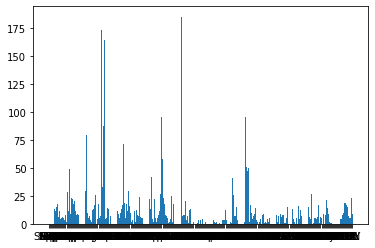

In [74]:
distinct_rois, roi_eid_counts = [r for r in eid_dic], [len(v) for v in eid_dic.values()]
plt.bar(distinct_rois, roi_eid_counts)

In [135]:
sorted_idx = np.argsort(roi_eid_counts)
top_rois = [distinct_rois[i] for i in sorted_idx[-20:]]
top_rois.reverse()

In [ ]:
len_left = 0
roilist = [top_rois[0]]
eidset = set(eid_dic[top_rois[0]])

reduc_list = top_rois[1:]
for i in range(len(top_rois)-1):
  if i == len(top_rois):
    break
  
  sublist = top_rois[i+1:]
  print(sublist)
  max_overlap = [0,'']
  for roi in reduc_list:
    overlapsize = len(eidset & set(eid_dic[roi]))
    if overlapsize > max_overlap[0]:
        max_overlap[0] = overlapsize
        max_overlap[1] = roi
  roilist.append(max_overlap[1])
  reduc_list.remove(max_overlap[1])

  
roilist

In [87]:
sorted_idx = np.argsort(roi_eid_counts)
top_rois = [distinct_rois[i] for i in sorted_idx[-50:]]
top_rois.reverse()


eidset = set(eid_dic[top_rois[0]])
best_arrangement = []


for j in range(10000):
  if j == 0:
    continue
  top_rois.shuffle
  for i,roi in enumerate(top_rois):
    if i == 0:
      continue
    eidset = eidset & set(eid_dic[top_rois[i]])
    print(len(eidset))

In [150]:
eidset = set(eid_dic[roilist[0]])
  
for i,roi in enumerate(roilist):
  if i == 0:
    continue
  eidset = eidset & set(eid_dic[roilist[i]])

  print(len(eidset))
  if i == 6:
    print(eidset)

91
78
59
18
10
9
{'4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24'}
0
0
0
0
0
0
0
0
0
0
0
0
0


In [145]:
roilist[:7]

['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']

In [151]:
rois_opt = roilist[:7]

eid_list = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24']
for eid in eid_list:
    eidset = set(roi_dic[eid]) & set(rois_opt)
    print(len(eidset) == len(rois_opt))

True
True
True
True
True
True
True
True
True


THE DATASET GENERATION

In [ ]:
eid_list = ['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '3e6a97d3-3991-49e2-b346-6948cb4580fb', 'ecb5520d-1358-434c-95ec-93687ecd1396', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'b22f694e-4a34-4142-ab9d-2556c3487086', '9b528ad0-4599-4a55-9148-96cc1d93fb24']
simul_regions = ['CM', 'DG', 'CA1', 'LP', 'MRN', 'PTLp', 'APN']
whole_dataset = {}
for eid in eid_list:
    region_2_dat = get_data_per_recording(eid, simul_regions)
    whole_dataset[eid] = region_2_dat

In [165]:
whole_dataset['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b']['CM'][1]['trial_data']['choices']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [168]:
whole_dataset['4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b']['CM'][1]['spike_counts'].shape

(252, 16, 120)

In [ ]:
for eid in whole_dataset.keys():
    

In [117]:
eid_cumulative = []
from collections import Counter
for roi in top_rois:
    eid_cumulative += eid_dic[roi]
eidcounts = Counter(eid_cumulative)
max(eidcounts.values())

16

In [110]:
sorted_eid = np.argsort(list(eidcounts.values()))
eid_relev = list(eidcounts.keys())
top50_eids = [eid_relev[i] for i in sorted_eid[-50:]]
top50_eids.reverse()
eidcounts[top50_eids[0]]

16

In [115]:
roi_dic[top50_eids[0]]

['VISpm',
 'RSPagl',
 'RSPd',
 'RSPv',
 'PTLp',
 'CA1',
 'CA2',
 'CA3',
 'DG',
 'VPL',
 'VPM',
 'LGd',
 'ZI',
 'SCs',
 'MRN',
 'SCm',
 'RN']

In [ ]:
roiset = set(roi_dic[top50_eids[0]])
for i,roi in enumerate(top50_eids):
    if i == 0:
      continue
    roiset = roiset & set(roi_dic[top50_eids[i]])
    print(len(roiset))

The EID with the most simultaneous recordings is: 2c44a360-5a56-4971-8009-f469fb59de98 with 19
Rois:  ['MOp', 'MOs', 'ACAd', 'ACAv', 'PL', 'ILA', 'TT', 'DP', 'CA3', 'DG', 'ACB', 'OT', 'LSr', 'SI', 'AMd', 'IAD', 'MD', 'PVT', 'CM']


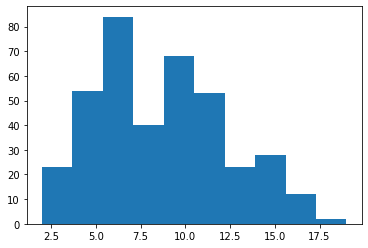

In [5]:
record_lens = [len(record) for record in roi_records]
highscore_ind = np.argmax(record_lens)

plt.hist(record_lens)

# highscore_ind is the index corresponding to an eid
# 
eid_most = all_eids[highscore_ind]
corr_regions = roi_records[highscore_ind]
print('The EID with the most simultaneous recordings is: ' + eid_most + ' with ' + str(len(corr_regions)))
print('Rois: ', corr_regions)

3) Dataset generation below

In [156]:

eid_most = '2c44a360-5a56-4971-8009-f469fb59de98'
corr_regions = ['MOp', 'MOs', 'ACAd', 'ACAv', 'PL', 'ILA', 'TT', 'DP', 'CA3', 'DG', 'ACB', 'OT', 'LSr', 'SI', 'AMd', 'IAD', 'MD', 'PVT', 'CM']

#this code is written for an eid with two pids (two probes)

def get_data_per_recording(eid, corr_regions):
    datalist = get_spikedata_eid(eid_most)
    trials = one.load_object(eid_most, 'trials')

    region_2_relevneur = {}
    region_2_data = {}

    # def get_matrices(trials, spikes, relev_neur, param = 'choice', param_condition = -1):
    count = 0
    for region in corr_regions:
        probe = 0
        relev_neur = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if region in acronym] #datalist[probe][1 = cluster]
        if len(relev_neur) == 0:
            probe = 1
            relev_neur = [i for i, acronym in enumerate(datalist[probe][1]['acronym']) if region in acronym]
        region_2_relevneur[region] = relev_neur
        
        dic = {}
        for condition in [-1,1]:
            mini_dic = {}
            peth, spike_counts, trial_data = get_matrices(trials, datalist[probe][0], relev_neur, param = 'choice', param_condition=condition)
            mini_dic['peth'] = peth
            mini_dic['spike_counts'] = spike_counts
            mini_dic['trial_data'] = trial_data
            dic[condition] = mini_dic
        region_2_data[region] = dic

    return region_2_data

In [17]:
diff = 0
for i,trial in enumerate(trials['goCueTrigger_times']):
    if i == len(trials['goCueTrigger_times'])-1:
        break
    diff += trials['goCueTrigger_times'][i+1] - trials['goCueTrigger_times'][i]
print(diff/i)

4.601481504547704


In [ ]:
#summarize dimensions
#peth means is neurons by time (averaged over trials)
#spike_counts is trials by neurons by time
#trial_data contains behavioral parameters (choice, feedback, movement_initiation_time, etc)

for roi in region_2_data:
    print('ROI: ', roi)
    for condition in [-1,1]:
        print('Choice: ', condition)
        print(region_2_data[roi][condition]['peth']['means'].shape)
        print(region_2_data[roi][condition]['spike_counts'].shape)
        print(region_2_data[roi][condition]['trial_data']['choices'].shape)

In [92]:
#first pass classification task
from sklearn.model_selection import train_test_split
from sklearn import metrics
def check_accuracy_peregion(region_2_data, model, squash = 'mean'):

    rois = region_2_data.keys()

    for ex_roi in rois:
        num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
        training_size = 480
        T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
        whole_data = []
        whole_outputs = []

        for condition in [-1,1]:
            spike_counts = region_2_data[ex_roi][condition]['spike_counts']
            if squash == 'mean':
                # print(spike_counts.shape)
                dat = np.mean(spike_counts, axis=1) #averaging over neurons
                # print(dat.shape)
            elif squash == 'vec':
                dat = spike_counts.reshape(spike_counts.shape[0],-1)

            whole_data.append(dat)
            whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
        whole_data = np.vstack(whole_data)
        whole_outputs = np.hstack(whole_outputs)
        print(whole_data.shape, whole_outputs.shape)

        X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Model Accuracy: how often is the classifier correct?
        print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

In [94]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(clf, squash = 'vec')

(600, 120) (600,)
MOp accuracy: 0.6166666666666667
(600, 120) (600,)
MOs accuracy: 0.6416666666666667
(600, 120) (600,)
ACAd accuracy: 0.5666666666666667
(600, 120) (600,)
ACAv accuracy: 0.5666666666666667
(600, 120) (600,)
PL accuracy: 0.7583333333333333
(600, 120) (600,)
ILA accuracy: 0.625
(600, 120) (600,)
TT accuracy: 0.6
(600, 120) (600,)
DP accuracy: 0.525
(600, 120) (600,)
CA3 accuracy: 0.675
(600, 120) (600,)
DG accuracy: 0.6416666666666667
(600, 120) (600,)
ACB accuracy: 0.5833333333333334
(600, 120) (600,)
OT accuracy: 0.5916666666666667
(600, 120) (600,)
LSr accuracy: 0.6416666666666667
(600, 120) (600,)
SI accuracy: 0.5666666666666667
(600, 120) (600,)
AMd accuracy: 0.6166666666666667
(600, 120) (600,)
IAD accuracy: 0.5833333333333334
(600, 120) (600,)
MD accuracy: 0.5833333333333334
(600, 120) (600,)
PVT accuracy: 0.6083333333333333
(600, 120) (600,)
CM accuracy: 0.5833333333333334

With vectorize
(600, 1800) (600,)
MOp accuracy: 0.6666666666666666
(600, 14040) (600,)
MOs

In [83]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
check_accuracy_peregion(clf, squash = 'mean')
print('\nWith vectorize')
check_accuracy_peregion(clf, squash = 'vec')

ValueError: ignored

In [73]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
check_accuracy_peregion(clf)

MOp accuracy: 0.5833333333333334
MOs accuracy: 0.6416666666666667
ACAd accuracy: 0.6833333333333333
ACAv accuracy: 0.6166666666666667
PL accuracy: 0.7166666666666667
ILA accuracy: 0.6583333333333333
TT accuracy: 0.5833333333333334
DP accuracy: 0.5666666666666667
CA3 accuracy: 0.6416666666666667
DG accuracy: 0.5583333333333333
ACB accuracy: 0.5833333333333334
OT accuracy: 0.5583333333333333
LSr accuracy: 0.5833333333333334
SI accuracy: 0.6
AMd accuracy: 0.5666666666666667
IAD accuracy: 0.6416666666666667
MD accuracy: 0.6
PVT accuracy: 0.6166666666666667
CM accuracy: 0.5833333333333334


In [74]:
from sklearn.linear_model import LogisticRegression
clf_logr = LogisticRegression(random_state=0)
check_accuracy_peregion(clf_logr)

MOp accuracy: 0.6083333333333333
MOs accuracy: 0.7166666666666667
ACAd accuracy: 0.7083333333333334
ACAv accuracy: 0.65
PL accuracy: 0.725
ILA accuracy: 0.7
TT accuracy: 0.625
DP accuracy: 0.5916666666666667
CA3 accuracy: 0.6333333333333333
DG accuracy: 0.6166666666666667
ACB accuracy: 0.675
OT accuracy: 0.5
LSr accuracy: 0.5583333333333333
SI accuracy: 0.625
AMd accuracy: 0.55
IAD accuracy: 0.6083333333333333
MD accuracy: 0.5916666666666667
PVT accuracy: 0.5583333333333333
CM accuracy: 0.55


In [67]:
#first pass classification task

rois = region_2_data.keys()
X_trains = None
X_tests = None

for ex_roi in rois:
    num_trials = region_2_data[ex_roi][-1]['trial_data']['choices'].shape[0] + region_2_data[ex_roi][1]['trial_data']['choices'].shape[0]
    training_size = 480

    T = region_2_data[ex_roi][1]['spike_counts'].shape[-1]
    whole_data = []
    whole_outputs = []

    for condition in [-1,1]:
        spike_counts = region_2_data[ex_roi][condition]['spike_counts']

        whole_data.append(dat)
        whole_outputs.append(region_2_data[ex_roi][condition]['trial_data']['choices'])
    whole_data = np.vstack(whole_data)
    whole_outputs = np.hstack(whole_outputs)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(whole_data, whole_outputs, test_size=0.2)
    if X_trains is None:
        X_trains = X_train
        X_tests = X_test
    else:
        print(X_trains.shape, X_train.shape)
        X_trains = np.hstack([X_trains, X_train])
        X_tests = np.hstack([X_tests, X_test])
    

print(X_trains.shape)
print(X_tests.shape)



(480, 15) (480, 117)
(480, 132) (480, 38)
(480, 170) (480, 33)
(480, 203) (480, 39)
(480, 242) (480, 212)
(480, 454) (480, 9)
(480, 463) (480, 3)
(480, 466) (480, 23)
(480, 489) (480, 27)
(480, 516) (480, 251)
(480, 767) (480, 4)
(480, 771) (480, 98)
(480, 869) (480, 55)
(480, 924) (480, 13)
(480, 937) (480, 27)
(480, 964) (480, 46)
(480, 1010) (480, 84)
(480, 1094) (480, 16)
(480, 1110)
(120, 1110)


In [68]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trains, y_train)
y_pred = clf.predict(X_tests)
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print(ex_roi + " accuracy:",metrics.accuracy_score(y_test, y_pred))

CM accuracy: 0.5833333333333334
